In [ ]:
# Credit to ERTUĞRUL DEMIR
# This part of code is based on his notebook.
# The part before modeling is run locally. The modeling is run on Google Colab. 

# Libraries for EDA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Sklearn packages for modeling. 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Packages for name entity recognition 

from collections import Counter, defaultdict
from PIL import Image


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import spacy
import en_core_web_sm

# Packages for general use. 

import random
import warnings
import time
import datetime

# Packages for plots. 

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Pytorch packages. 

import torch

In [ ]:
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

In [ ]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Set options for general use. 

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

# Set seeds for consistent results. 

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
train = pd.read_csv('newtrain.csv')
test = pd.read_csv('newtest.csv')

In [ ]:
display(train.sample(5))
display(test.sample(5))

,text,label,text_clean,tokenized,lower
6071,families to sue over legionnaires more than 40...,1,families to sue over legionnaires more than 40...,"[families, to, sue, over, legionnaires, more, ...","[families, to, sue, over, legionnaires, more, ..."
12571,another rescued mumma koala with her little ne...,1,another rescued mumma koala with her little ne...,"[another, rescued, mumma, koala, with, her, li...","[another, rescued, mumma, koala, with, her, li..."
12706,the liberal project is to tear down remake am...,0,the liberal project is to tear down remake am...,"[the, liberal, project, is, to, tear, down, re...","[the, liberal, project, is, to, tear, down, re..."
4305,not to angelise iuml however cant help but say...,0,not to angelise iuml however cant help but say...,"[not, to, angelise, iuml, however, cant, help,...","[not, to, angelise, iuml, however, cant, help,..."
4520,and then theres that hum,0,and then theres that hum,"[and, then, theres, that, hum]","[and, then, theres, that, hum]"


,text,label
3372,crazy storm hit and im trapped inside a hobby ...,1
4965,first impression yo this guys hs art is nuts y...,0
1731,japan heat wave intensifies ûò death toll sur...,1
1755,i am saddened by the unfortunate news of the m...,1
724,how to restore vinyl siding and make it look n...,0


In [ ]:
print(train.shape)
print(test.shape)

(12951, 2)
(5551, 2)


In [ ]:
# Remove urls, emojis, html tags and punctuations. 

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        u'\U0001F914'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

train['text_clean'] = train['text'].apply(lambda x: remove_URL(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_emoji(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_html(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_punct(x))

In [ ]:
train.keys()

Index(['text', 'label', 'text_clean'], dtype='object')

In [ ]:
# Tokenize the tweet texts.

train['tokenized'] = train['text_clean'].apply(word_tokenize)

train.head()

,text,label,text_clean,tokenized
0,news alert issues impacting drivers license se...,0,news alert issues impacting drivers license se...,"[news, alert, issues, impacting, drivers, lice..."
1,if itûªs a war you came to see you will never...,0,if itûªs a war you came to see you will never...,"[if, itûªs, a, war, you, came, to, see, you, ..."
2,sgt david edward lloyd one of the few killed ...,0,sgt david edward lloyd one of the few killed ...,"[sgt, david, edward, lloyd, one, of, the, few,..."
3,x and to counter acts such as the burning of t...,1,x and to counter acts such as the burning of t...,"[x, and, to, counter, acts, such, as, the, bur..."
4,no ways pe needs to be burned down,0,no ways pe needs to be burned down,"[no, ways, pe, needs, to, be, burned, down]"


In [ ]:
# Lowercase the tokenized texts.

train['lower'] = train['tokenized'].apply(
    lambda x: [word.lower() for word in x])

train.head()

,text,label,text_clean,tokenized,lower
0,news alert issues impacting drivers license se...,0,news alert issues impacting drivers license se...,"[news, alert, issues, impacting, drivers, lice...","[news, alert, issues, impacting, drivers, lice..."
1,if itûªs a war you came to see you will never...,0,if itûªs a war you came to see you will never...,"[if, itûªs, a, war, you, came, to, see, you, ...","[if, itûªs, a, war, you, came, to, see, you, ..."
2,sgt david edward lloyd one of the few killed ...,0,sgt david edward lloyd one of the few killed ...,"[sgt, david, edward, lloyd, one, of, the, few,...","[sgt, david, edward, lloyd, one, of, the, few,..."
3,x and to counter acts such as the burning of t...,1,x and to counter acts such as the burning of t...,"[x, and, to, counter, acts, such, as, the, bur...","[x, and, to, counter, acts, such, as, the, bur..."
4,no ways pe needs to be burned down,0,no ways pe needs to be burned down,"[no, ways, pe, needs, to, be, burned, down]","[no, ways, pe, needs, to, be, burned, down]"


In [ ]:
# Remove stopwords.

train['stopwords_removed'] = train['lower'].apply(
    lambda x: [word for word in x if word not in stop])

train.head()

,text,label,text_clean,tokenized,lower,stopwords_removed
0,news alert issues impacting drivers license se...,0,news alert issues impacting drivers license se...,"[news, alert, issues, impacting, drivers, lice...","[news, alert, issues, impacting, drivers, lice...","[news, alert, issues, impacting, drivers, lice..."
1,if itûªs a war you came to see you will never...,0,if itûªs a war you came to see you will never...,"[if, itûªs, a, war, you, came, to, see, you, ...","[if, itûªs, a, war, you, came, to, see, you, ...","[itûªs, war, came, see, never, see, waved, wh..."
2,sgt david edward lloyd one of the few killed ...,0,sgt david edward lloyd one of the few killed ...,"[sgt, david, edward, lloyd, one, of, the, few,...","[sgt, david, edward, lloyd, one, of, the, few,...","[sgt, david, edward, lloyd, one, killed, colli..."
3,x and to counter acts such as the burning of t...,1,x and to counter acts such as the burning of t...,"[x, and, to, counter, acts, such, as, the, bur...","[x, and, to, counter, acts, such, as, the, bur...","[x, counter, acts, burning, alexandrian, library]"
4,no ways pe needs to be burned down,0,no ways pe needs to be burned down,"[no, ways, pe, needs, to, be, burned, down]","[no, ways, pe, needs, to, be, burned, down]","[ways, pe, needs, burned]"


In [ ]:
# Add 'part of speech' tags.

train['pos_tags'] = train['stopwords_removed'].apply(nltk.tag.pos_tag)

train.head()

,text,label,text_clean,tokenized,lower,stopwords_removed,pos_tags
0,news alert issues impacting drivers license se...,0,news alert issues impacting drivers license se...,"[news, alert, issues, impacting, drivers, lice...","[news, alert, issues, impacting, drivers, lice...","[news, alert, issues, impacting, drivers, lice...","[(news, NN), (alert, NN), (issues, NNS), (impa..."
1,if itûªs a war you came to see you will never...,0,if itûªs a war you came to see you will never...,"[if, itûªs, a, war, you, came, to, see, you, ...","[if, itûªs, a, war, you, came, to, see, you, ...","[itûªs, war, came, see, never, see, waved, wh...","[(itûªs, JJ), (war, NN), (came, VBD), (see, V..."
2,sgt david edward lloyd one of the few killed ...,0,sgt david edward lloyd one of the few killed ...,"[sgt, david, edward, lloyd, one, of, the, few,...","[sgt, david, edward, lloyd, one, of, the, few,...","[sgt, david, edward, lloyd, one, killed, colli...","[(sgt, NN), (david, VBZ), (edward, RB), (lloyd..."
3,x and to counter acts such as the burning of t...,1,x and to counter acts such as the burning of t...,"[x, and, to, counter, acts, such, as, the, bur...","[x, and, to, counter, acts, such, as, the, bur...","[x, counter, acts, burning, alexandrian, library]","[(x, JJ), (counter, NN), (acts, NNS), (burning..."
4,no ways pe needs to be burned down,0,no ways pe needs to be burned down,"[no, ways, pe, needs, to, be, burned, down]","[no, ways, pe, needs, to, be, burned, down]","[ways, pe, needs, burned]","[(ways, NNS), (pe, VBP), (needs, NNS), (burned..."


In [ ]:
# Convert texts with part of speech tags to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


train['wordnet_pos'] = train['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

train.head()

,text,label,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,news alert issues impacting drivers license se...,0,news alert issues impacting drivers license se...,"[news, alert, issues, impacting, drivers, lice...","[news, alert, issues, impacting, drivers, lice...","[news, alert, issues, impacting, drivers, lice...","[(news, NN), (alert, NN), (issues, NNS), (impa...","[(news, n), (alert, n), (issues, n), (impactin..."
1,if itûªs a war you came to see you will never...,0,if itûªs a war you came to see you will never...,"[if, itûªs, a, war, you, came, to, see, you, ...","[if, itûªs, a, war, you, came, to, see, you, ...","[itûªs, war, came, see, never, see, waved, wh...","[(itûªs, JJ), (war, NN), (came, VBD), (see, V...","[(itûªs, a), (war, n), (came, v), (see, v), (..."
2,sgt david edward lloyd one of the few killed ...,0,sgt david edward lloyd one of the few killed ...,"[sgt, david, edward, lloyd, one, of, the, few,...","[sgt, david, edward, lloyd, one, of, the, few,...","[sgt, david, edward, lloyd, one, killed, colli...","[(sgt, NN), (david, VBZ), (edward, RB), (lloyd...","[(sgt, n), (david, v), (edward, r), (lloyd, a)..."
3,x and to counter acts such as the burning of t...,1,x and to counter acts such as the burning of t...,"[x, and, to, counter, acts, such, as, the, bur...","[x, and, to, counter, acts, such, as, the, bur...","[x, counter, acts, burning, alexandrian, library]","[(x, JJ), (counter, NN), (acts, NNS), (burning...","[(x, a), (counter, n), (acts, n), (burning, v)..."
4,no ways pe needs to be burned down,0,no ways pe needs to be burned down,"[no, ways, pe, needs, to, be, burned, down]","[no, ways, pe, needs, to, be, burned, down]","[ways, pe, needs, burned]","[(ways, NNS), (pe, VBP), (needs, NNS), (burned...","[(ways, n), (pe, v), (needs, n), (burned, v)]"


In [ ]:
# Apply word lemmatizer. 

wnl = WordNetLemmatizer()

train['lemmatized'] = train['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

train['lemmatized'] = train['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

train['lemma_str'] = [' '.join(map(str, l)) for l in train['lemmatized']]

train.head()

,text,label,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,news alert issues impacting drivers license se...,0,news alert issues impacting drivers license se...,"[news, alert, issues, impacting, drivers, lice...","[news, alert, issues, impacting, drivers, lice...","[news, alert, issues, impacting, drivers, lice...","[(news, NN), (alert, NN), (issues, NNS), (impa...","[(news, n), (alert, n), (issues, n), (impactin...","[news, alert, issue, impact, driver, license, ...",news alert issue impact driver license service...
1,if itûªs a war you came to see you will never...,0,if itûªs a war you came to see you will never...,"[if, itûªs, a, war, you, came, to, see, you, ...","[if, itûªs, a, war, you, came, to, see, you, ...","[itûªs, war, came, see, never, see, waved, wh...","[(itûªs, JJ), (war, NN), (came, VBD), (see, V...","[(itûªs, a), (war, n), (came, v), (see, v), (...","[itûªs, war, come, see, never, see, waved, wh...",itûªs war come see never see waved white flag...
2,sgt david edward lloyd one of the few killed ...,0,sgt david edward lloyd one of the few killed ...,"[sgt, david, edward, lloyd, one, of, the, few,...","[sgt, david, edward, lloyd, one, of, the, few,...","[sgt, david, edward, lloyd, one, killed, colli...","[(sgt, NN), (david, VBZ), (edward, RB), (lloyd...","[(sgt, n), (david, v), (edward, r), (lloyd, a)...","[sgt, david, edward, lloyd, one, kill, collide...",sgt david edward lloyd one kill collide anothe...
3,x and to counter acts such as the burning of t...,1,x and to counter acts such as the burning of t...,"[x, and, to, counter, acts, such, as, the, bur...","[x, and, to, counter, acts, such, as, the, bur...","[x, counter, acts, burning, alexandrian, library]","[(x, JJ), (counter, NN), (acts, NNS), (burning...","[(x, a), (counter, n), (acts, n), (burning, v)...","[x, counter, act, burn, alexandrian, library]",x counter act burn alexandrian library
4,no ways pe needs to be burned down,0,no ways pe needs to be burned down,"[no, ways, pe, needs, to, be, burned, down]","[no, ways, pe, needs, to, be, burned, down]","[ways, pe, needs, burned]","[(ways, NNS), (pe, VBP), (needs, NNS), (burned...","[(ways, n), (pe, v), (needs, n), (burned, v)]","[way, pe, need, burn]",way pe need burn


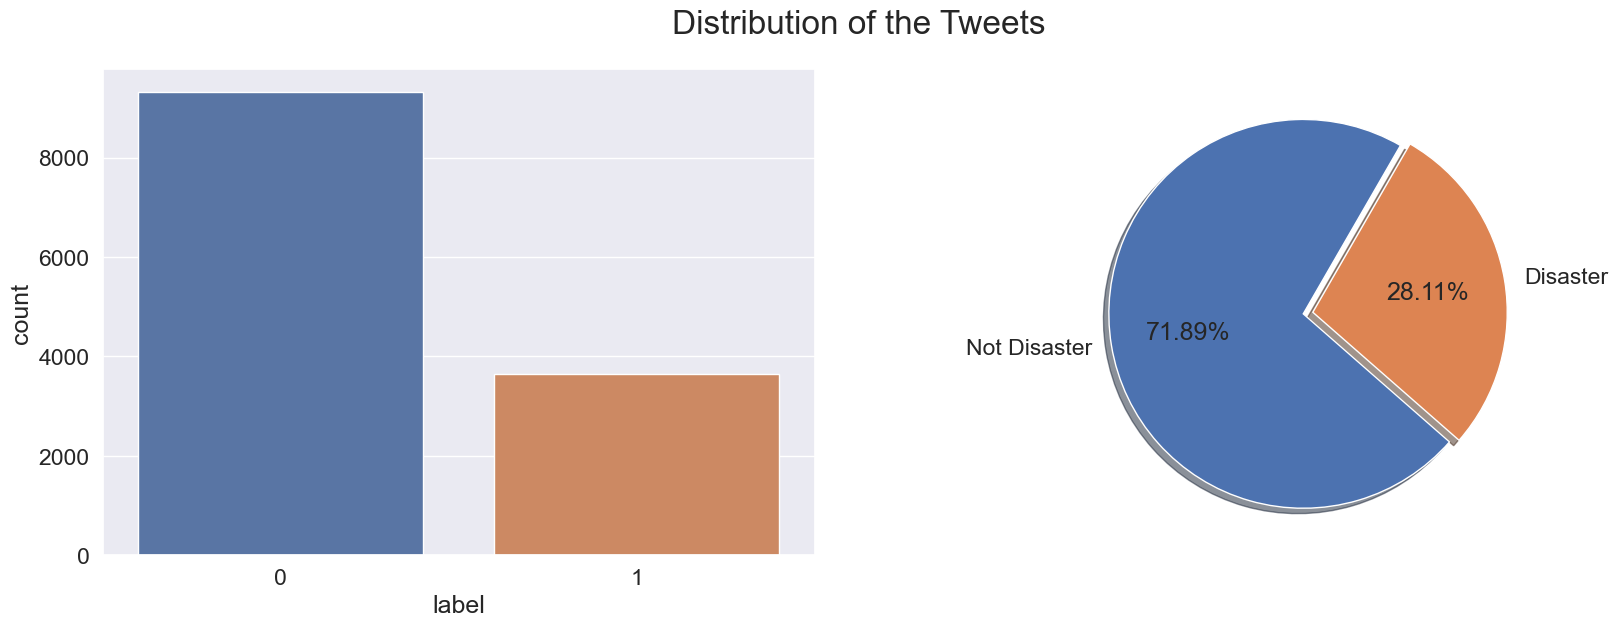

In [ ]:
# Display target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(train['label'], ax=axes[0])
axes[1].pie(train['label'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

In [ ]:
lis = [
    train[train['label'] == 0]['lemma_str'],
    train[train['label'] == 1]['lemma_str']
]

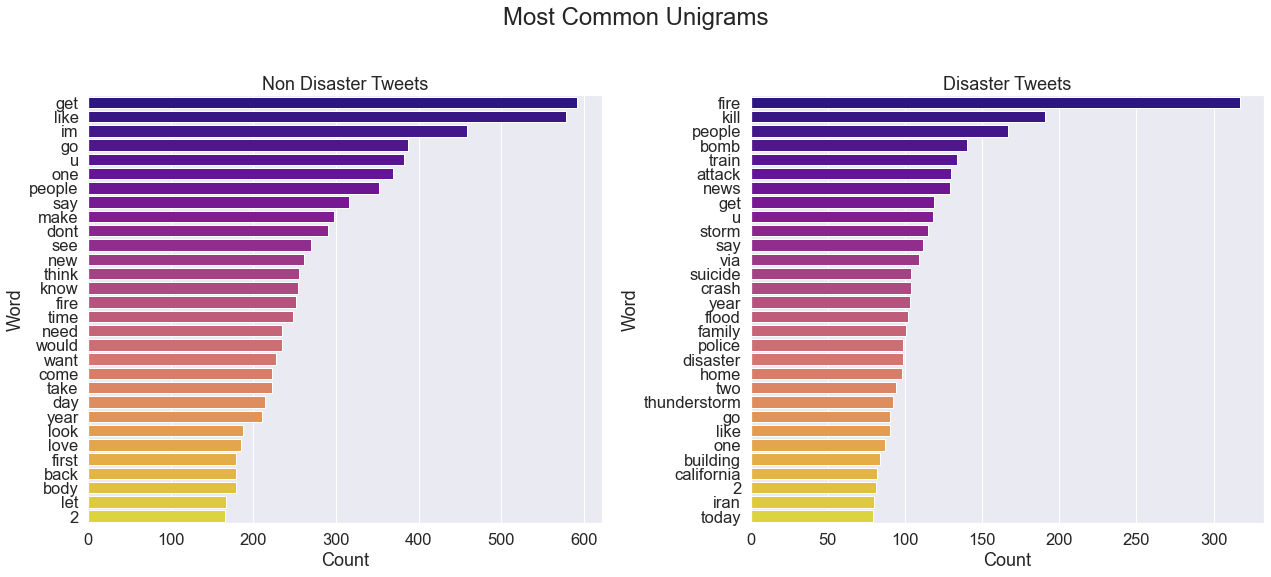

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Non Disaster Tweets')

axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()


In [ ]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

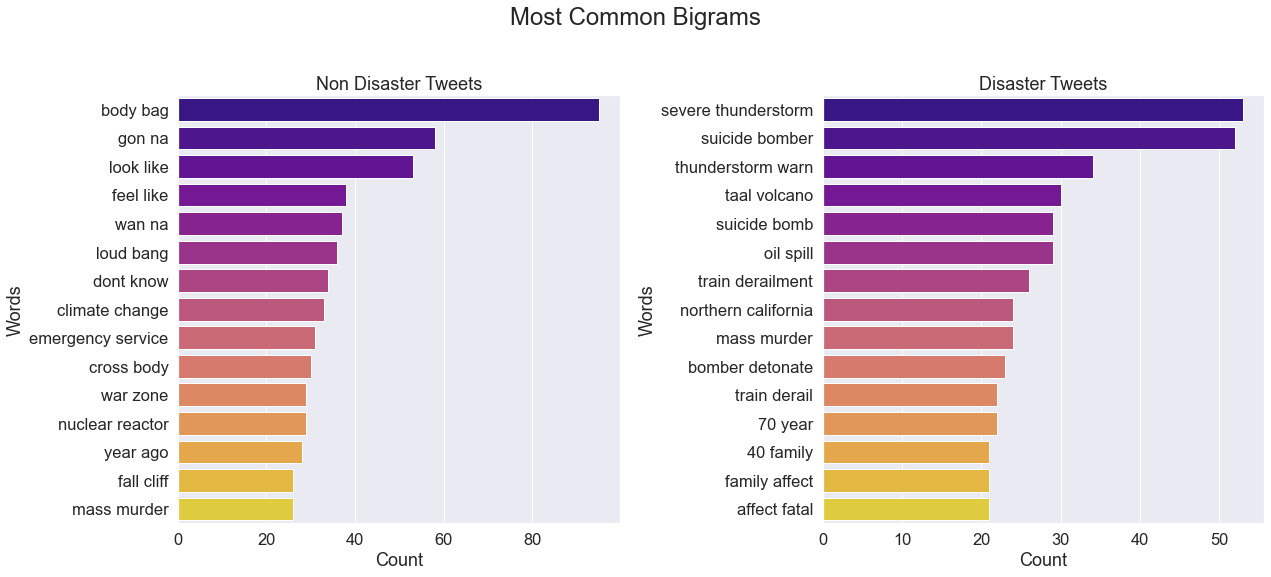

In [ ]:
ngrams(2, 'Most Common Bigrams')

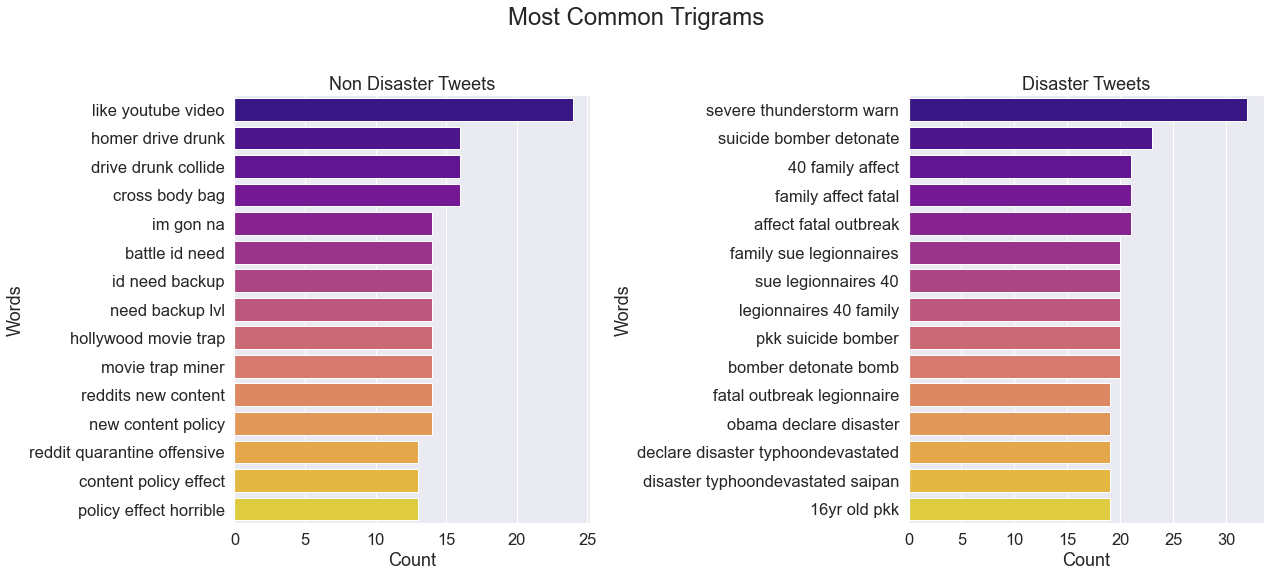

In [ ]:
ngrams(3, 'Most Common Trigrams')

In [ ]:
nlp = en_core_web_sm.load() 

In [ ]:
def plot_named_entity_barchart(text):
    
    """A function for extracting named entities and comparing them"""
    
    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)
    

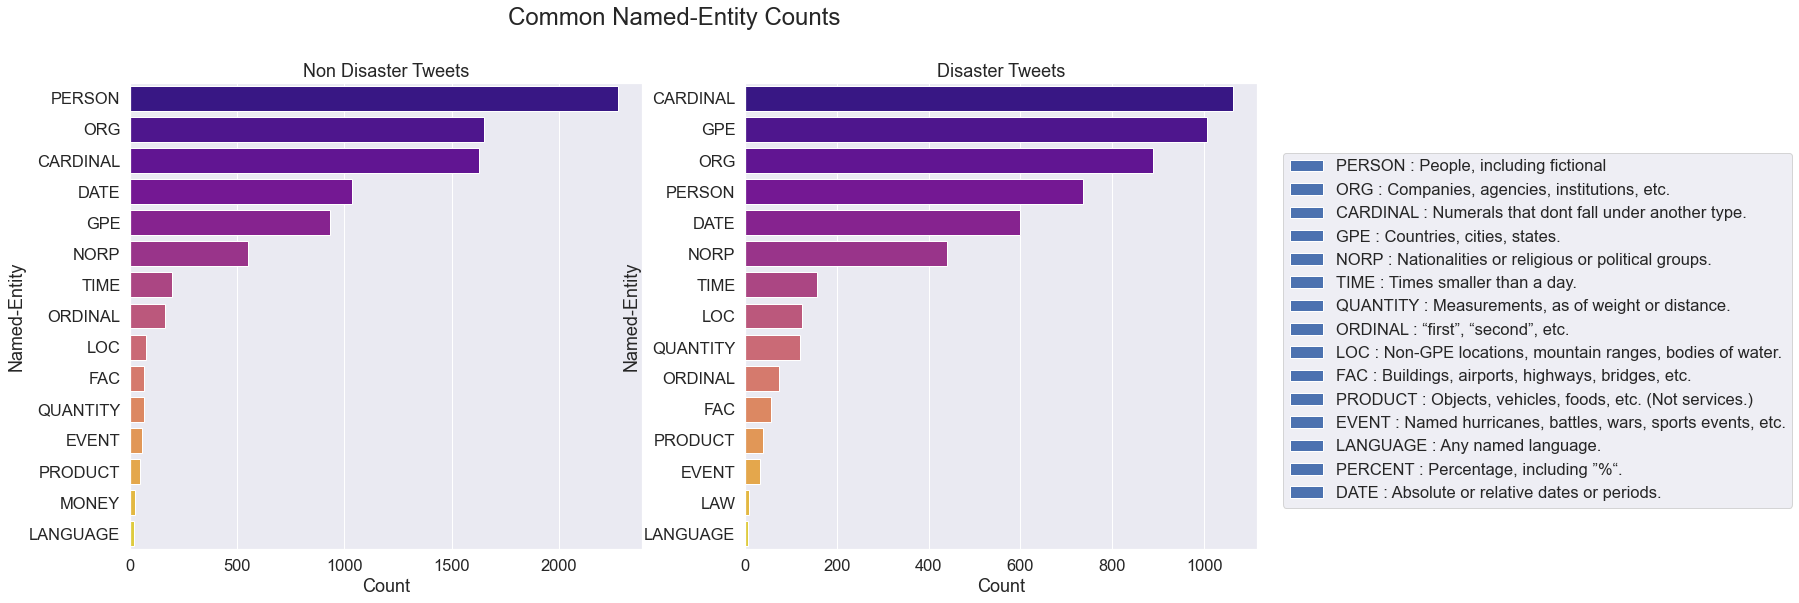

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

In [ ]:
#Connect with google drive to import data files. The previous part is run locally.
#The following part is run on Google Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the old trainset and new testset for modeling.
train = pd.read_csv('/content/drive/MyDrive/5100Project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/5100Project/newtest.csv')

# Set variales for modeling. combine train and test data for tokenization. 
train_labels = train['target'].values
test_labels = test['label'].values
idx = len(labels)
combined = pd.concat([train, test])
combined = combined.text.values

In [ ]:
from transformers import AutoModel, AutoTokenizer

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # Use the 12-layer, 110M parameters BERT model with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
print(' Original: ', combined[0])

# Print the tokens.

print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the token IDs of words in a sentence.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

 Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [ ]:
#Get max_len of a sentence for padding. 
max_len = 0

for text in combined:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    # We update the max_len once we have a longer sentence. 
    max_len = max(max_len, len(input_ids))
print('Max:', max_len)

Max: 84


In [ ]:
# Split train and test data based on idx
print(idx)
train = combined[:idx]
test = combined[idx:]
print(train.shape)
print(test.shape)
print(train[0])
print(test[0])

7613
(7613,)
(5551,)
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
amazondeals skylanders trap team flip wreck character pack  down 453 045 to 949 from 994 sale


In [ ]:
# Credit to ERTUĞRUL DEMIR
def tokenize_map(sentence, labels):
    
    """A function for tokenize all of the sentences and map the tokens to their word IDs."""
    input_ids = []
    attention_masks = []

    # For every sentence...
    
    for text in sentence:
        #   "encode_plus" will:
        
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 84,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list. 
        
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels
   

In [ ]:
# Tokenize all of data(both train and test) and map the tokens to their word IDs. 
input_ids, attention_masks, train_labels = tokenize_map(train, train_labels)
test_input_ids, test_attention_masks, test_labels= tokenize_map(test, test_labels)

In [ ]:
# Combine the training inputs into a TensorDataset.
trainset = TensorDataset(input_ids, attention_masks, labels)
testset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [ ]:
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoaders for our training and test sets.
# We'll take training samples in random order. 

train_dataloader = DataLoader(
            trainset,  # The training samples.
            sampler = RandomSampler(trainset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For test, the order doesn't matter, so we'll just read them sequentially.

test_dataloader = DataLoader(
            testset, # The test samples.
            sampler = SequentialSampler(testset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
optimizer = AdamW(model.parameters(), lr = 6e-6, eps = 1e-8)

In [ ]:
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    
    """A function for calculating accuracy scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    
    """A function for calculating f1 scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, pred_flat)

In [ ]:
def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.  
    
    device = torch.device('cuda')    


    print('There are %d GPU(s) available.' % torch.cuda.device_count())

There are 1 GPU(s) available.


In [ ]:
# This training code is based on the `run_glue.py` script and ERTUĞRUL DEMIR's notebook
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# https://www.kaggle.com/datafan07/disaster-tweets-nlp-eda-bert-with-transformers

model.to(device)
# Stores a number of metrics such as training and test loss, test accuracy, f1 score and time used.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes:
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    
    # Start training
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Update progress every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)

       
        #Clear gradients
        model.zero_grad()
        
        #Evaluate the model of this batch by performing a forward pass. 
        #Logits are the model outputs prior to actication. 
        temp = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss, logits = temp[0], temp[1]
        total_train_loss += loss.item() 
        loss.backward()
        # Clip the norm of the gradients to 1.0. This helps to prevent the 'exploding gradients' problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        optimizer.step()
        scheduler.step()
        
    # Calculate the total average loss of all the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long one epoch takes.
    training_time = format_time(time.time() - t0)
    print('')
    print('  Average training loss: {0:.4f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))
        
    # ========================================
    #               Test
    # ========================================
    # After the completion of each training epoch, evaluate the model with the test set.

    print('')
    print('Testing...')
    t0 = time.time()
    model.eval()

    # Tracking variables:
    total_test_accuracy = 0
    total_test_loss = 0
    total_test_f1 = 0
    nb_test_steps = 0

    # Evaluate data for one epoch.
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():    
            temp = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = temp[0]
        logits = temp[1]
        total_test_loss += loss.item()    

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_test_accuracy += flat_accuracy(logits, label_ids)
        total_test_f1 += flat_f1(logits, label_ids)
        
    avg_test_accuracy = total_test_accuracy / len(test_dataloader)
    print('  Accuracy: {0:.4f}'.format(avg_test_accuracy))
    
    avg_test_f1 = total_test_f1 / len(test_dataloader)
    print('  F1: {0:.4f}'.format(avg_test_f1))
    avg_test_loss = total_test_loss / len(test_dataloader)
    test_time = format_time(time.time() - t0)
    
    print('  Test Loss: {0:.4f}'.format(avg_test_loss))
    print('  Test took: {:}'.format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Test Loss': avg_test_loss,
            'Test Accur.': avg_test_accuracy,
            'F1' : avg_test_f1,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )
    
print('')
print('Training complete!')
print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))



======== Epoch 1 / 3 ========
Training...
  Batch    50  of    238.    Elapsed: 0:00:46.
  Batch   100  of    238.    Elapsed: 0:01:31.
  Batch   150  of    238.    Elapsed: 0:02:17.
  Batch   200  of    238.    Elapsed: 0:03:02.

  Average training loss: 0.3390
  Training epcoh took: 0:03:37

Testing...
  Accuracy: 0.8184
  F1: 0.7081
  Test Loss: 0.4491
  Test took: 0:00:57

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    238.    Elapsed: 0:00:45.
  Batch   100  of    238.    Elapsed: 0:01:31.
  Batch   150  of    238.    Elapsed: 0:02:16.
  Batch   200  of    238.    Elapsed: 0:03:02.

  Average training loss: 0.3371
  Training epcoh took: 0:03:36

Testing...
  Accuracy: 0.8184
  F1: 0.7081
  Test Loss: 0.4491
  Test took: 0:00:57

======== Epoch 3 / 3 ========
Training...
  Batch    50  of    238.    Elapsed: 0:00:46.
  Batch   100  of    238.    Elapsed: 0:01:31.
  Batch   150  of    238.    Elapsed: 0:02:16.
  Batch   200  of    238.    Elapsed: 0:03:02.

  Averag